In [1]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("tapakah68/supervisely-filtered-segmentation-person-dataset")

# print("Path to dataset files:", path)

In [13]:
# Install required packages if not already installed
# !pip install torch torchvision albumentations matplotlib scikit-learn

import os
import random
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.model_selection import train_test_split


In [14]:
# Adjust parameters
input_size = (256, 256)  # Height, Width
batch_size = 8  # Options: 8, 16, 32
seed = 42
epochs = 50

# Set random seeds for reproducibility
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [15]:
# Directories of data
image_folder = "/kaggle/input/supervisely-filtered-segmentation-person-dataset/supervisely_person_clean_2667_img/supervisely_person_clean_2667_img/images"
mask_folder = "/kaggle/input/supervisely-filtered-segmentation-person-dataset/supervisely_person_clean_2667_img/supervisely_person_clean_2667_img/masks"

# Get sorted list of image and mask paths
image_paths = sorted([
    os.path.join(image_folder, img) for img in os.listdir(image_folder) if img.endswith(".png")
])
mask_paths = sorted([
    os.path.join(mask_folder, mask) for mask in os.listdir(mask_folder) if mask.endswith(".png")
])

# Ensure that image and mask counts match
assert len(image_paths) == len(mask_paths), "Number of images and masks do not match."


In [16]:
# Split data into training and temporary (validation + test) sets
X_train, X_temp, y_train, y_temp = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=seed
)

# Further split temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=seed
)

print(f"Training set:   X: {len(X_train)}, y: {len(y_train)}")
print(f"Validation set: X: {len(X_val)}, y: {len(y_val)}")
print(f"Test set:       X: {len(X_test)}, y: {len(y_test)}")


Training set:   X: 2133, y: 2133
Validation set: X: 267, y: 267
Test set:       X: 267, y: 267


In [17]:
class SegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        """
        Args:
            image_paths (list): List of image file paths.
            mask_paths (list): List of mask file paths.
            transform (albumentations.Compose): Optional transform to be applied
                on a sample.
        """
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image
        image = np.array(Image.open(self.image_paths[idx]).convert("RGB"))
        
        # Load mask
        mask = np.array(Image.open(self.mask_paths[idx]).convert("L"))
        mask = np.expand_dims(mask, axis=-1)  # Add channel dimension
        
        # Normalize mask to [0,1]
        mask = mask / 255.0
        mask = np.round(mask).astype(np.float32)
        
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        else:
            # If no transform is provided, convert to tensor
            image = T.ToTensor()(Image.fromarray(image))
            mask = torch.from_numpy(mask.transpose((2, 0, 1))).float()
        
        return image, mask

# more transform for better generalization in training
train_transform = A.Compose([
    A.Resize(height=input_size[0], width=input_size[1]),
    A.Rotate(limit=45, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.03, scale_limit=0.03, rotate_limit=0, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Affine(shear=(-10, 10), p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.RandomResizedCrop(height=input_size[0], width=input_size[1], scale=(0.97, 1.0), p=0.5),

    A.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0)),
    ToTensorV2()
])
#for val we just need to process the image
val_test_transform = A.Compose([
    A.Resize(height=input_size[0], width=input_size[1]),
    A.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0)),
    ToTensorV2()
])


# Create Dataset instances
train_dataset = SegmentationDataset(X_train, y_train, transform=train_transform)
val_dataset = SegmentationDataset(X_val, y_val, transform=val_test_transform)
test_dataset = SegmentationDataset(X_test, y_test, transform=val_test_transform)

# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)


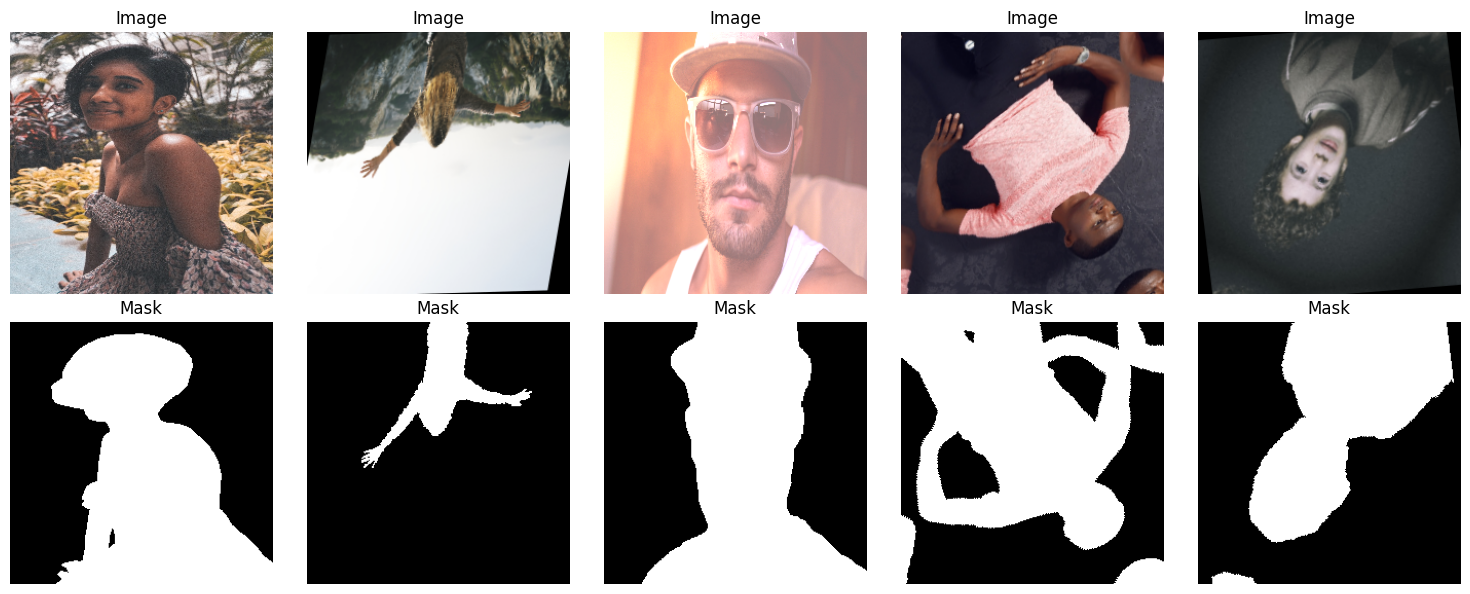

In [18]:
# Function to visualize images and masks
def visualize_batch(images, masks, num_samples=5):
    images = images.permute(0, 2, 3, 1).cpu().numpy()  # Convert to HWC
    masks = masks.cpu().numpy()
    
    plt.figure(figsize=(15, 6))
    for i in range(num_samples):
        # Display Image
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(images[i])
        plt.title("Image")
        plt.axis('off')
        
        # Display Mask
        plt.subplot(2, num_samples, i + 1 + num_samples)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title("Mask")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Get a batch of training data
train_iter = iter(train_loader)
images, masks = next(train_iter)

# Visualize the batch
visualize_batch(images, masks, num_samples=5)


In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet101
import torchvision
import cv2
import numpy as np
import torch.optim as optim
# Helper function to replace BatchNorm2d with GroupNorm
def replace_bn_with_gn(module, num_groups=32):
    """
    Recursively replace all nn.BatchNorm2d layers with nn.GroupNorm in a module.
    """
    for name, child in module.named_children():
        if isinstance(child, nn.BatchNorm2d):
            num_channels = child.num_features
            # Ensure num_channels is divisible by num_groups
            if num_channels % num_groups != 0:
                # Find the largest divisor of num_channels less than or equal to num_groups
                for ng in range(num_groups, 0, -1):
                    if num_channels % ng == 0:
                        num_groups = ng
                        break
            # Replace BatchNorm2d with GroupNorm
            setattr(module, name, nn.GroupNorm(num_groups=num_groups, num_channels=num_channels))
        else:
            replace_bn_with_gn(child, num_groups=num_groups)

# Atrous Convolution with GroupNorm
# Atrous Separable Convolution with GroupNorm
class AtrousSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, rate, num_groups=32):
        super(AtrousSeparableConv, self).__init__()
        # Depthwise Atrous Convolution
        self.depthwise = nn.Conv2d(
            in_channels, in_channels, kernel_size=3, padding=rate, dilation=rate, groups=in_channels, bias=False
        )
        self.gn_depthwise = nn.GroupNorm(num_groups=num_groups, num_channels=in_channels)
        
        # Pointwise Convolution
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.gn_pointwise = nn.GroupNorm(num_groups=num_groups, num_channels=out_channels)
        
        self.relu = nn.ReLU()
    
    def forward(self, x):
        # Apply depthwise atrous convolution
        x = self.relu(self.gn_depthwise(self.depthwise(x)))
        # Apply pointwise convolution
        x = self.relu(self.gn_pointwise(self.pointwise(x)))
        return x


# Atrous Spatial Pyramid Pooling (ASPP) Module with Atrous Separable Convolution
class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels, num_groups=32):
        super(ASPP, self).__init__()
        self.conv1x1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.GroupNorm(num_groups=num_groups, num_channels=out_channels),
            nn.ReLU()
        )
        self.conv3x3_r6 = AtrousSeparableConv(in_channels, out_channels, rate=6, num_groups=num_groups)
        self.conv3x3_r12 = AtrousSeparableConv(in_channels, out_channels, rate=12, num_groups=num_groups)
        self.conv3x3_r18 = AtrousSeparableConv(in_channels, out_channels, rate=18, num_groups=num_groups)
        self.global_avg_pool = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.GroupNorm(num_groups=num_groups, num_channels=out_channels),
            nn.ReLU()
        )
        self.concat_conv = nn.Sequential(
            nn.Conv2d(out_channels * 5, out_channels, kernel_size=1, bias=False),
            nn.GroupNorm(num_groups=num_groups, num_channels=out_channels),
            nn.ReLU()
        )
    
    def forward(self, x):
        size = x.shape[-2:]
        conv1x1 = self.conv1x1(x)
        conv3x3_r6 = self.conv3x3_r6(x)
        conv3x3_r12 = self.conv3x3_r12(x)
        conv3x3_r18 = self.conv3x3_r18(x)
        global_avg_pool = F.interpolate(
            self.global_avg_pool(x), size=size, mode='bilinear', align_corners=False
        )
        concatenated = torch.cat([conv1x1, conv3x3_r6, conv3x3_r12, conv3x3_r18, global_avg_pool], dim=1)
        return self.concat_conv(concatenated)

# DeepLabv3 Encoder with GroupNorm and Debugging
class DeepLabv3Encoder(nn.Module):
    def __init__(self, output_stride=16, num_groups=32):
        super(DeepLabv3Encoder, self).__init__()
        # Determine dilation rates based on output_stride
        if output_stride == 16:
            replace_stride_with_dilation = [False, True, True]
        elif output_stride == 8:
            replace_stride_with_dilation = [False, False, True]
        else:
            raise ValueError("Output stride must be either 8 or 16")
    
        # Load ResNet-101 backbone with dilated convolutions
        resnet = resnet101(
            weights=torchvision.models.ResNet101_Weights.DEFAULT,
            replace_stride_with_dilation=replace_stride_with_dilation
        )
        # Replace all BatchNorm2d with GroupNorm
        replace_bn_with_gn(resnet, num_groups=num_groups)
        
        self.conv1 = resnet.conv1
        self.gn1 = resnet.bn1  # Now GroupNorm
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        self.layer1 = resnet.layer1  # Block1
        self.layer2 = resnet.layer2  # Block2
        self.layer3 = resnet.layer3  # Block3 with dilation
        self.layer4 = resnet.layer4  # Block4 with dilation
    
        # ASPP Module
        self.aspp = ASPP(2048, 256, num_groups=num_groups)
    
    def forward(self, x):
        # print(f"Input shape: {x.shape}")
        # Backbone feature extraction
        x = self.conv1(x)
        # print(f"After conv1: {x.shape}")
        x = self.gn1(x)  # GroupNorm
        x = self.relu(x)
        x = self.maxpool(x)
        # print(f"After maxpool: {x.shape}")
        
        low_level_features = self.layer1(x)  # Low-level features for decoder
        # print(f"After layer1 (low_level_features): {low_level_features.shape}")
        
        x = self.layer2(low_level_features)
        # print(f"After layer2: {x.shape}")
        x = self.layer3(x)
        # print(f"After layer3: {x.shape}")
        x = self.layer4(x)
        # print(f"After layer4: {x.shape}")
        
        # ASPP Module
        x = self.aspp(x)
        # print(f"After ASPP: {x.shape}")
    
        return x, low_level_features  

class DeepLabv3Decoder(nn.Module):
    def __init__(self, low_level_in_channels=256, low_level_out_channels=48, num_classes=21, num_groups_decoder=16):
        super(DeepLabv3Decoder, self).__init__()
        # 1x1 convolution to reduce low-level features channels
        self.low_level_conv = nn.Sequential(
            nn.Conv2d(low_level_in_channels, low_level_out_channels, kernel_size=1, bias=False),
            nn.GroupNorm(num_groups=num_groups_decoder, num_channels=low_level_out_channels),
            nn.ReLU()
        )
        
        
        self.concat_conv = nn.Sequential(
            nn.Conv2d(256 + low_level_out_channels, 256, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(num_groups=num_groups_decoder, num_channels=256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(num_groups=num_groups_decoder, num_channels=256),
            nn.ReLU(),
            nn.Conv2d(256, num_classes, kernel_size=1)
        )
    
    def forward(self, high_level_features, low_level_features):
        low_level = self.low_level_conv(low_level_features)
        # print(f"After low_level_conv: {low_level.shape}")
        # Upsample high-level features to low-level spatial dimensions
        high_level_upsampled = F.interpolate(high_level_features, size=low_level.shape[2:], mode='bilinear', align_corners=False)
        # print(f"After upsampling high_level_features: {high_level_upsampled.shape}")
        # Concatenate
        concatenated = torch.cat([high_level_upsampled, low_level], dim=1)
        # print(f"After concatenation: {concatenated.shape}")
        # Apply convolutions
        out = self.concat_conv(concatenated)
        # print(f"After concat_conv: {out.shape}")
        return out


class DeepLabv3(nn.Module):
    def __init__(self, num_classes=21, output_stride=16, num_groups_encoder=32, num_groups_decoder=16):
        super(DeepLabv3, self).__init__()
        self.encoder = DeepLabv3Encoder(output_stride=output_stride, num_groups=num_groups_encoder)
        self.decoder = DeepLabv3Decoder(low_level_in_channels=256, low_level_out_channels=48, num_classes=num_classes, num_groups_decoder=num_groups_decoder)
    
    def forward(self, x):
        high_level_features, low_level_features = self.encoder(x)
        out = self.decoder(high_level_features, low_level_features)
        # Upsample to input image size
        out = F.interpolate(out, size=x.shape[2:], mode='bilinear', align_corners=False)
        # print(f"Final output shape: {out.shape}")
        return out



def create_trimap(seg_map, erode_kernel_size=5, dilate_kernel_size=5):
    """
    Refines the segmentation map into a trimap using erosion and dilation.
    
    Args:
        seg_map (np.ndarray): Segmentation map with class labels.
        erode_kernel_size (int): Kernel size for erosion.
        dilate_kernel_size (int): Kernel size for dilation.
    
    Returns:
        np.ndarray: Refined trimap.
    """
    # Define class labels
    BACKGROUND = 0
    UNKNOWN = 1
    FOREGROUND = 2
    
    # Create binary masks
    foreground = (seg_map == FOREGROUND).astype(np.uint8)
    background = (seg_map == BACKGROUND).astype(np.uint8)
    
    # Define kernels
    erode_kernel = np.ones((erode_kernel_size, erode_kernel_size), np.uint8)
    dilate_kernel = np.ones((dilate_kernel_size, dilate_kernel_size), np.uint8)
    
    # Erode foreground to ensure separation
    eroded_foreground = cv2.erode(foreground, erode_kernel, iterations=1)
    
    # Dilate background to ensure separation
    dilated_background = cv2.dilate(background, dilate_kernel, iterations=1)
    
    # Define unknown region
    unknown = cv2.bitwise_and(dilated_background, cv2.bitwise_not(eroded_foreground))
    
    # Create trimap
    trimap = np.full(seg_map.shape, UNKNOWN, dtype=np.uint8)  # Initialize all as unknown
    trimap[eroded_foreground == 1] = FOREGROUND
    trimap[background == 1] = BACKGROUND
    
    return trimap


In [32]:
import os
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm  # Progress bar (optional)

# Ensure you're in the right environment
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Paths for saving the model
model_dir = "./models"
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, "best_model.pth")

# Test if the save path works
try:
    with open(os.path.join(model_dir, "test.txt"), "w") as f:
        f.write("Testing write permissions.")
    os.remove(os.path.join(model_dir, "test.txt"))
    print("Path is valid and writable.")
except Exception as e:
    print(f"Error with save path: {e}")
    raise

# Define your model (assuming DeepLabv3 is defined elsewhere)
model = DeepLabv3(num_classes=1, output_stride=16, num_groups_encoder=32, num_groups_decoder=16)
model = model.to(device)

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Number of epochs
num_epochs = 50

# Best loss for saving checkpoints
best_loss = float("inf")
patience = 5  # Early stopping patience
counter = 0

# Training and validation loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_loss = 0.0

    print(f"\nEpoch [{epoch+1}/{num_epochs}] - Training")
    for batch_idx, (images, masks) in enumerate(tqdm(train_loader, desc="Training")):
        images = images.to(device)  # Move images to GPU
        masks = masks.to(device)   # Move masks to GPU

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks.squeeze(-1).unsqueeze(1))  # Squeeze and unsqueeze mask

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track epoch loss
        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {avg_train_loss:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0

    print(f"Epoch [{epoch+1}/{num_epochs}] - Validation")
    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc="Validation"):
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks.squeeze(-1).unsqueeze(1))
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Validation Loss: {avg_val_loss:.4f}")

    # Save the best model
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        counter = 0
        torch.save(model.state_dict(), model_path)
        print(f"Model saved at epoch {epoch+1} with validation loss {avg_val_loss:.4f}")
    else:
        counter += 1
        print(f"No improvement for {counter} epochs.")

    # Early stopping
    if counter >= patience:
        print("Early stopping triggered.")
        break

# Zip the model for download
zip_path = shutil.make_archive("models", "zip", model_dir)
print(f"Model saved and zipped as: {zip_path}")

# Download the model automatically in Kaggle
from IPython.display import FileLink
print("Click the link below to download your model:")
display(FileLink("models.zip"))


Using device: cuda
Path is valid and writable.

Epoch [1/50] - Training


Training: 100%|██████████| 267/267 [03:43<00:00,  1.20it/s]


Epoch [1/50] Train Loss: 0.4019
Epoch [1/50] - Validation


Validation: 100%|██████████| 34/34 [00:12<00:00,  2.63it/s]


Epoch [1/50] Validation Loss: 0.3245
Model saved at epoch 1 with validation loss 0.3245

Epoch [2/50] - Training


Training: 100%|██████████| 267/267 [03:43<00:00,  1.20it/s]


Epoch [2/50] Train Loss: 0.2910
Epoch [2/50] - Validation


Validation: 100%|██████████| 34/34 [00:11<00:00,  2.88it/s]


Epoch [2/50] Validation Loss: 0.2005
Model saved at epoch 2 with validation loss 0.2005

Epoch [3/50] - Training


Training: 100%|██████████| 267/267 [03:43<00:00,  1.20it/s]


Epoch [3/50] Train Loss: 0.2304
Epoch [3/50] - Validation


Validation: 100%|██████████| 34/34 [00:12<00:00,  2.82it/s]


Epoch [3/50] Validation Loss: 0.1732
Model saved at epoch 3 with validation loss 0.1732

Epoch [4/50] - Training


Training: 100%|██████████| 267/267 [03:43<00:00,  1.19it/s]


Epoch [4/50] Train Loss: 0.2051
Epoch [4/50] - Validation


Validation: 100%|██████████| 34/34 [00:11<00:00,  2.88it/s]


Epoch [4/50] Validation Loss: 0.1505
Model saved at epoch 4 with validation loss 0.1505

Epoch [5/50] - Training


Training: 100%|██████████| 267/267 [03:43<00:00,  1.19it/s]


Epoch [5/50] Train Loss: 0.1860
Epoch [5/50] - Validation


Validation: 100%|██████████| 34/34 [00:12<00:00,  2.82it/s]


Epoch [5/50] Validation Loss: 0.1656
No improvement for 1 epochs.

Epoch [6/50] - Training


Training: 100%|██████████| 267/267 [03:43<00:00,  1.19it/s]


Epoch [6/50] Train Loss: 0.1793
Epoch [6/50] - Validation


Validation: 100%|██████████| 34/34 [00:11<00:00,  2.85it/s]


Epoch [6/50] Validation Loss: 0.1379
Model saved at epoch 6 with validation loss 0.1379

Epoch [7/50] - Training


Training: 100%|██████████| 267/267 [03:43<00:00,  1.20it/s]


Epoch [7/50] Train Loss: 0.1626
Epoch [7/50] - Validation


Validation: 100%|██████████| 34/34 [00:11<00:00,  2.87it/s]


Epoch [7/50] Validation Loss: 0.1329
Model saved at epoch 7 with validation loss 0.1329

Epoch [8/50] - Training


Training: 100%|██████████| 267/267 [03:44<00:00,  1.19it/s]


Epoch [8/50] Train Loss: 0.1530
Epoch [8/50] - Validation


Validation: 100%|██████████| 34/34 [00:11<00:00,  2.92it/s]


Epoch [8/50] Validation Loss: 0.1246
Model saved at epoch 8 with validation loss 0.1246

Epoch [9/50] - Training


Training: 100%|██████████| 267/267 [03:43<00:00,  1.20it/s]


Epoch [9/50] Train Loss: 0.1488
Epoch [9/50] - Validation


Validation: 100%|██████████| 34/34 [00:11<00:00,  2.87it/s]


Epoch [9/50] Validation Loss: 0.1183
Model saved at epoch 9 with validation loss 0.1183

Epoch [10/50] - Training


Training: 100%|██████████| 267/267 [03:43<00:00,  1.19it/s]


Epoch [10/50] Train Loss: 0.1369
Epoch [10/50] - Validation


Validation: 100%|██████████| 34/34 [00:11<00:00,  2.88it/s]


Epoch [10/50] Validation Loss: 0.1289
No improvement for 1 epochs.

Epoch [11/50] - Training


Training: 100%|██████████| 267/267 [03:43<00:00,  1.19it/s]


Epoch [11/50] Train Loss: 0.1445
Epoch [11/50] - Validation


Validation: 100%|██████████| 34/34 [00:11<00:00,  2.92it/s]


Epoch [11/50] Validation Loss: 0.1195
No improvement for 2 epochs.

Epoch [12/50] - Training


Training: 100%|██████████| 267/267 [03:43<00:00,  1.19it/s]


Epoch [12/50] Train Loss: 0.1297
Epoch [12/50] - Validation


Validation: 100%|██████████| 34/34 [00:12<00:00,  2.83it/s]


Epoch [12/50] Validation Loss: 0.1134
Model saved at epoch 12 with validation loss 0.1134

Epoch [13/50] - Training


Training: 100%|██████████| 267/267 [03:44<00:00,  1.19it/s]


Epoch [13/50] Train Loss: 0.1279
Epoch [13/50] - Validation


Validation: 100%|██████████| 34/34 [00:11<00:00,  2.87it/s]


Epoch [13/50] Validation Loss: 0.1009
Model saved at epoch 13 with validation loss 0.1009

Epoch [14/50] - Training


Training: 100%|██████████| 267/267 [03:44<00:00,  1.19it/s]


Epoch [14/50] Train Loss: 0.1301
Epoch [14/50] - Validation


Validation: 100%|██████████| 34/34 [00:12<00:00,  2.76it/s]


Epoch [14/50] Validation Loss: 0.1058
No improvement for 1 epochs.

Epoch [15/50] - Training


Training: 100%|██████████| 267/267 [03:43<00:00,  1.19it/s]


Epoch [15/50] Train Loss: 0.1316
Epoch [15/50] - Validation


Validation: 100%|██████████| 34/34 [00:11<00:00,  2.90it/s]


Epoch [15/50] Validation Loss: 0.1095
No improvement for 2 epochs.

Epoch [16/50] - Training


Training: 100%|██████████| 267/267 [03:43<00:00,  1.19it/s]


Epoch [16/50] Train Loss: 0.1221
Epoch [16/50] - Validation


Validation: 100%|██████████| 34/34 [00:12<00:00,  2.82it/s]


Epoch [16/50] Validation Loss: 0.1145
No improvement for 3 epochs.

Epoch [17/50] - Training


Training: 100%|██████████| 267/267 [03:43<00:00,  1.20it/s]


Epoch [17/50] Train Loss: 0.1103
Epoch [17/50] - Validation


Validation: 100%|██████████| 34/34 [00:11<00:00,  2.90it/s]


Epoch [17/50] Validation Loss: 0.1006
Model saved at epoch 17 with validation loss 0.1006

Epoch [18/50] - Training


Training: 100%|██████████| 267/267 [03:43<00:00,  1.20it/s]


Epoch [18/50] Train Loss: 0.1177
Epoch [18/50] - Validation


Validation: 100%|██████████| 34/34 [00:11<00:00,  2.90it/s]


Epoch [18/50] Validation Loss: 0.0968
Model saved at epoch 18 with validation loss 0.0968

Epoch [19/50] - Training


Training: 100%|██████████| 267/267 [03:43<00:00,  1.19it/s]


Epoch [19/50] Train Loss: 0.1156
Epoch [19/50] - Validation


Validation: 100%|██████████| 34/34 [00:11<00:00,  2.90it/s]


Epoch [19/50] Validation Loss: 0.0885
Model saved at epoch 19 with validation loss 0.0885

Epoch [20/50] - Training


Training: 100%|██████████| 267/267 [03:43<00:00,  1.20it/s]


Epoch [20/50] Train Loss: 0.1032
Epoch [20/50] - Validation


Validation: 100%|██████████| 34/34 [00:11<00:00,  2.91it/s]


Epoch [20/50] Validation Loss: 0.1137
No improvement for 1 epochs.

Epoch [21/50] - Training


Training: 100%|██████████| 267/267 [03:44<00:00,  1.19it/s]


Epoch [21/50] Train Loss: 0.1178
Epoch [21/50] - Validation


Validation: 100%|██████████| 34/34 [00:12<00:00,  2.81it/s]


Epoch [21/50] Validation Loss: 0.1030
No improvement for 2 epochs.

Epoch [22/50] - Training


Training: 100%|██████████| 267/267 [03:43<00:00,  1.20it/s]


Epoch [22/50] Train Loss: 0.1059
Epoch [22/50] - Validation


Validation: 100%|██████████| 34/34 [00:11<00:00,  2.89it/s]


Epoch [22/50] Validation Loss: 0.0965
No improvement for 3 epochs.

Epoch [23/50] - Training


Training: 100%|██████████| 267/267 [03:43<00:00,  1.20it/s]


Epoch [23/50] Train Loss: 0.1104
Epoch [23/50] - Validation


Validation: 100%|██████████| 34/34 [00:12<00:00,  2.75it/s]


Epoch [23/50] Validation Loss: 0.1369
No improvement for 4 epochs.

Epoch [24/50] - Training


Training: 100%|██████████| 267/267 [03:43<00:00,  1.20it/s]


Epoch [24/50] Train Loss: 0.1143
Epoch [24/50] - Validation


Validation: 100%|██████████| 34/34 [00:11<00:00,  2.85it/s]


Epoch [24/50] Validation Loss: 0.0925
No improvement for 5 epochs.
Early stopping triggered.
Model saved and zipped as: /kaggle/working/models.zip
Click the link below to download your model:


/kaggle/working/models.zip

<ipython-input-60-0a94395f8174>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


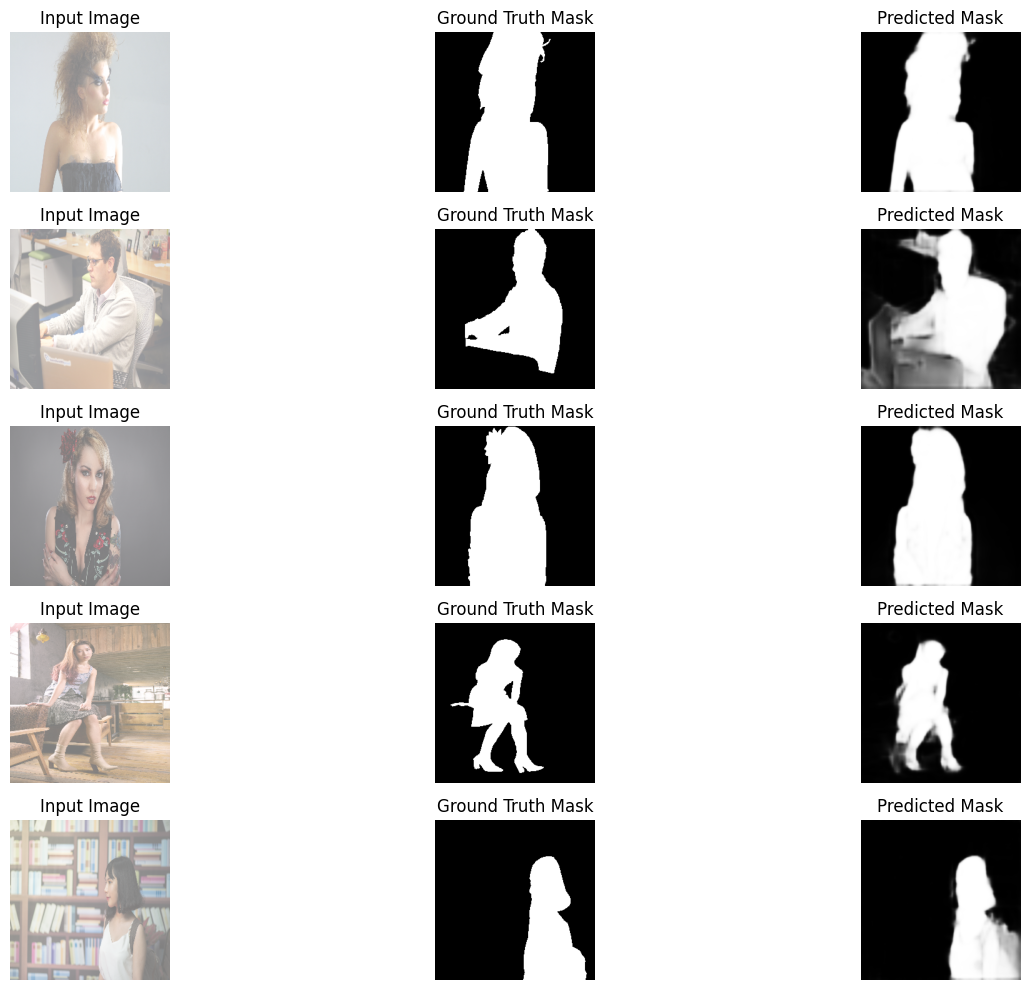

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Load the trained model
model = DeepLabv3(num_classes=1, output_stride=16, num_groups_encoder=32, num_groups_decoder=16)
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()

# Function to denormalize and display images
def denormalize_image(image_tensor):
    """Denormalize the image tensor for visualization."""
    image = image_tensor.permute(1, 2, 0).cpu().numpy()  # Change to HWC format
    image = (image * 0.5) + 0.5  # Reverse normalization (mean=0.5, std=0.5)
    image = np.clip(image, 0, 1)  # Clip values to [0, 1]
    return image

# Predict on the test dataset
num_images_to_display = 5  # Number of images to display
test_iter = iter(test_loader)
images, masks = next(test_iter)  # Get one batch of test data
images = images.to(device)
masks = masks.to(device)

# Perform predictions
with torch.no_grad():
    predicted_masks = model(images)
    predicted_masks = torch.sigmoid(predicted_masks).squeeze(1).cpu().numpy()  # Convert to [0, 1] range

# Visualize the results
plt.figure(figsize=(15, 10))
for i in range(num_images_to_display):
    # Input image
    plt.subplot(num_images_to_display, 3, i * 3 + 1)
    plt.imshow(denormalize_image(images[i]))
    plt.title("Input Image")
    plt.axis("off")

    # Ground truth mask
    plt.subplot(num_images_to_display, 3, i * 3 + 2)
    plt.imshow(masks[i].squeeze().cpu().numpy(), cmap="gray")
    plt.title("Ground Truth Mask")
    plt.axis("off")

    # Predicted mask
    plt.subplot(num_images_to_display, 3, i * 3 + 3)
    plt.imshow(predicted_masks[i], cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")

plt.tight_layout()
plt.show()


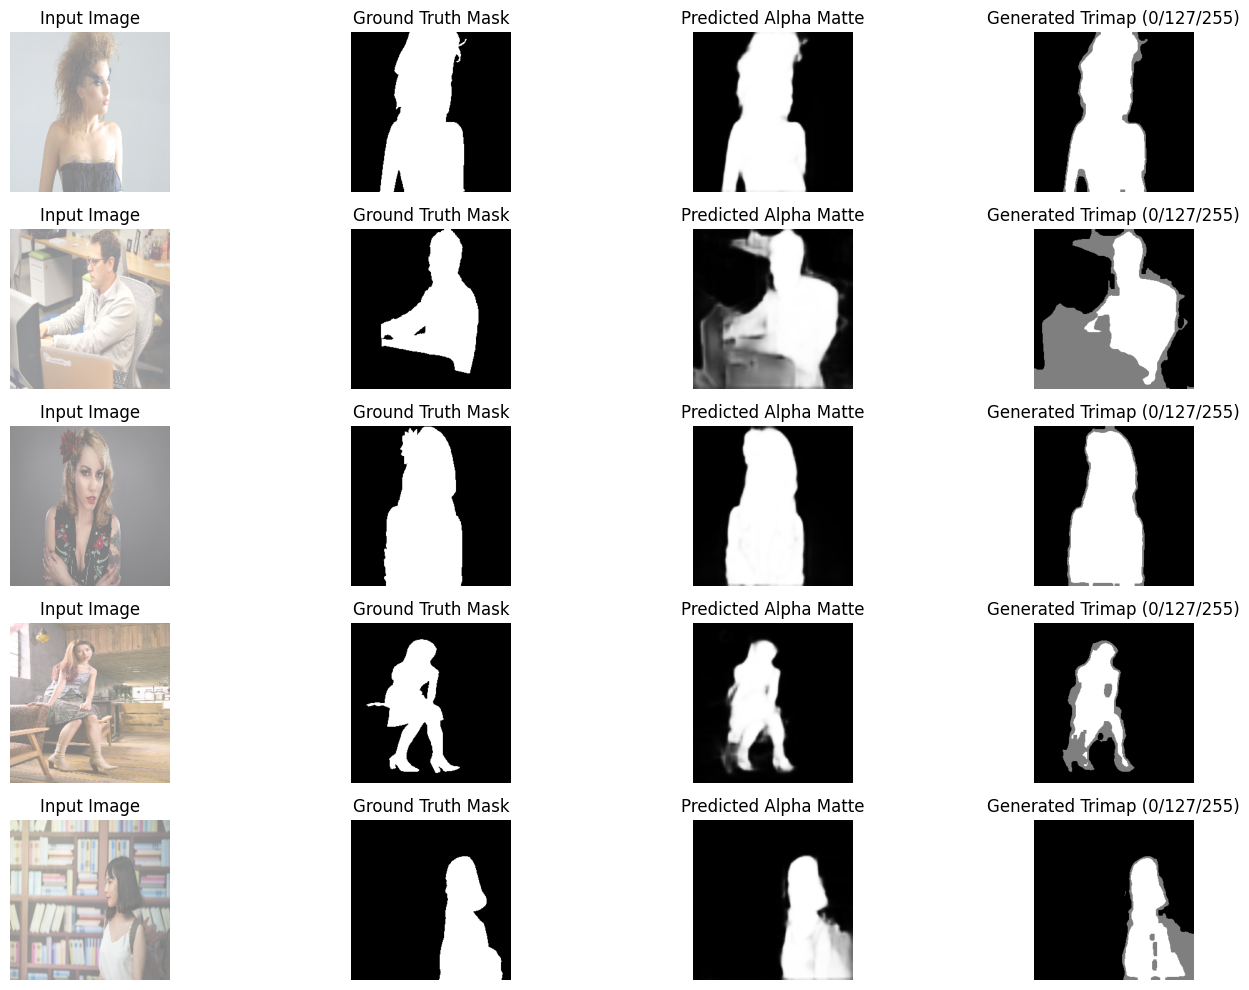

In [61]:
#def apply_postprocessing_colored(alpha_matte, fg_threshold=0.995, bg_threshold=0.005, erode_kernel_size=5, dilate_kernel_size=5):
def apply_postprocessing_colored(alpha_matte, fg_threshold=0, bg_threshold=1, erode_kernel_size=5, dilate_kernel_size=5):

    # Threshold for background, foreground, and unknown regions
    background = (alpha_matte <= bg_threshold).astype(np.uint8)  # Background region
    foreground = (alpha_matte >= fg_threshold).astype(np.uint8)  # Foreground region

    # Erode foreground (shrink foreground)
    erode_kernel = np.ones((erode_kernel_size, erode_kernel_size), np.uint8)
    eroded_foreground = cv2.erode(foreground, erode_kernel, iterations=1)

    # Dilate background (expand background)
    dilate_kernel = np.ones((dilate_kernel_size, dilate_kernel_size), np.uint8)
    dilated_background = cv2.dilate(background, dilate_kernel, iterations=1)

    # Define the unknown region
    unknown_region = ((alpha_matte > bg_threshold) & (alpha_matte < fg_threshold)).astype(np.uint8)

    # Create the trimap with custom values
    trimap = np.full(alpha_matte.shape, 127, dtype=np.uint8)  # Initialize all as unknown (127)
    trimap[eroded_foreground == 1] = 255  # Foreground (white)
    trimap[dilated_background == 1] = 0   # Background (black)

    return trimap


# Apply postprocessing and visualize
plt.figure(figsize=(15, 10))
for i in range(num_images_to_display):
    # Input image
    plt.subplot(num_images_to_display, 4, i * 4 + 1)
    plt.imshow(denormalize_image(images[i]))
    plt.title("Input Image")
    plt.axis("off")
    
    # Ground truth mask
    plt.subplot(num_images_to_display, 4, i * 4 + 2)
    plt.imshow(masks[i].squeeze().cpu().numpy(), cmap="gray")
    plt.title("Ground Truth Mask")
    plt.axis("off")
    
    # Predicted alpha matte
    plt.subplot(num_images_to_display, 4, i * 4 + 3)
    alpha_matte = predicted_masks[i]  # Alpha matte (probabilities)
    plt.imshow(alpha_matte, cmap="gray")
    plt.title("Predicted Alpha Matte")
    plt.axis("off")
    
    # Generated trimap with colors
    trimap = apply_postprocessing_colored(alpha_matte, fg_threshold=0.9, bg_threshold=0.1, erode_kernel_size=5, dilate_kernel_size=5)
    plt.subplot(num_images_to_display, 4, i * 4 + 4)
    plt.imshow(trimap, cmap="gray")  # Display trimap with gray colormap
    plt.title("Generated Trimap (0/127/255)")
    plt.axis("off")

plt.tight_layout()
plt.show()